<a href="https://colab.research.google.com/github/Omar-Ouardighi/Remaining-Useful-Life-RUL-Prediction/blob/main/CMAPSS_FD001_classical_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remaining Useful Life (RUL) Prediction

In this notebook, we will apply SVR, RandomForestRegressor to predict RUL of NASA's turbofan engine dataset FD001.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/CMAPSSData/train_FD001.txt', sep='\s+', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

In [4]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [5]:
len(np.unique(train_df[0]))

100

In [6]:
cycles_to_fail = train_df.groupby(0)[1].count()
cycles_to_fail

0
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: 1, Length: 100, dtype: int64

In [7]:
def process_targets(data_length):
    """ 
    Takes datalength (i.e., total number of cycles for each engine) and 
    creates target rul using linear degradation model.
    """
    return np.arange(data_length-1, -1, -1)
    


Now for any engine, we can find RUL values for both models. For example, we will take engine 4. From above we find that engine 4 fails after 189 cycles. So its data_length is 189.


Text(0.5, 1.0, 'Linear degradation model (engine 4)')

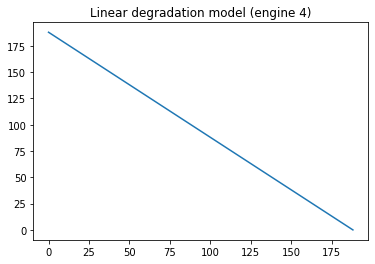

In [8]:
engin4_lr_degredation_rul = process_targets(189)
plt.plot(engin4_lr_degredation_rul)
plt.title('Linear degradation model (engine 4)')


# importing Test data and Rul values

Test data are similar to train data with only one difference. While for training data, data are available until failure for each engine, for test data, it is available for an arbitrary number of cycles. Using the given test data, out goal is to predict RUL. For test data, true RUL values are also available so that we can compare the performance of our prediction algorithm.


In [9]:
test_df = pd.read_csv('/content/drive/MyDrive/CMAPSSData/test_FD001.txt', sep='\s+', header=None)
print(test_df.shape)
test_df.head()

(13096, 26)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [10]:
true_rul = pd.read_csv('/content/drive/MyDrive/CMAPSSData/RUL_FD001.txt', sep = '\s+', header = None)
true_rul[0].values

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

We will feed our model only sensor measurement (6-26 columns). First two columns of training data contain engine and cycle information respectively, columns 3-5 contain operational settings. we wont use those data in our analysis

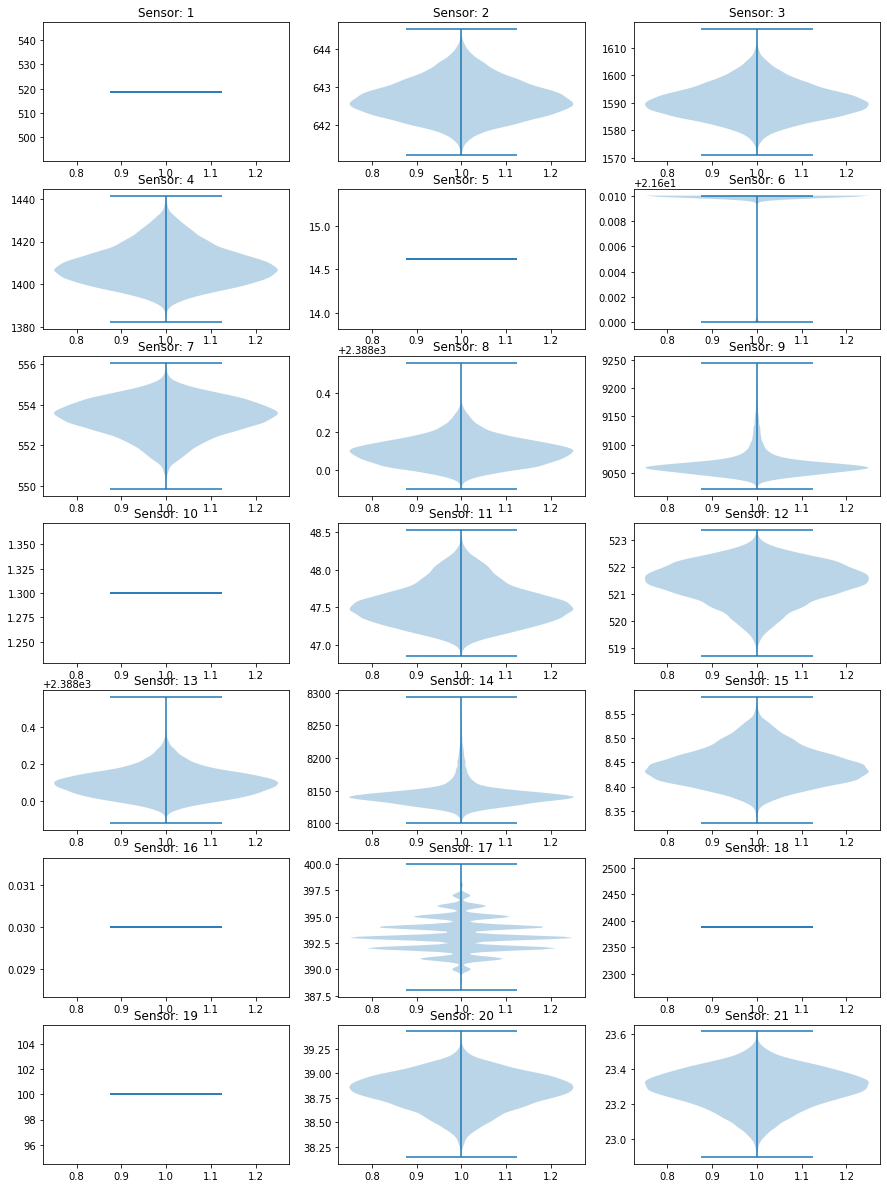

In [11]:
plt.figure(figsize = (15, 21))
for i in np.arange(5, 26):        
    temp = train_df.iloc[:, i]
    plt.subplot(7,3, i-4)
    plt.violinplot(temp)
    plt.title("Sensor: "+ str(i-4))
plt.show()

From the above plot we see that columns 6, 10, 15, 21, 23, and 24 contain constant values. It also appears that Column 11 also contains only a few different values.
we are going to drop these column in our analysis

In [12]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [13]:


data = np.array([[1,2,3,4,5],
                 [6,7,8,9,10],
                 [11,12,13,14,15],
                 [16,17,18,19,20],
                 [21,22,23,24,25],
                 [26,27,28,29,30]])
ruls = np.array([31,32,33,34,35,36])
print("Data:")
print(data)
print()
print("RUL:")
print(ruls)



Data:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]
 [26 27 28 29 30]]

RUL:
[31 32 33 34 35 36]


In [14]:
check_data, check_rul = process_input_data_with_targets(data,target_data = ruls, window_length = 3, shift = 1)
print(check_data)
print()
print(check_rul)

[[[ 1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]]

 [[ 6.  7.  8.  9. 10.]
  [11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]]

 [[11. 12. 13. 14. 15.]
  [16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]]

 [[16. 17. 18. 19. 20.]
  [21. 22. 23. 24. 25.]
  [26. 27. 28. 29. 30.]]]

[33. 34. 35. 36.]


## Preprocessing test data

In [15]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler helps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [16]:
check_data = np.reshape(np.arange(24), newshape = (6,4))
check_data

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])

In [17]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 2, shift = 1, num_test_windows= 1)
print(last_examples)
print()
print(num_last_examples)

[[[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]

1


In [18]:
window_length = 1
shift = 1
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_df[0]
test_data_first_column = test_df[0]

# Scale data for all engines
scaler = StandardScaler()
train_df = scaler.fit_transform(train_df.drop(columns = columns_to_be_dropped))
test_df = scaler.transform(test_df.drop(columns = columns_to_be_dropped))

train_df = pd.DataFrame(data = np.c_[train_data_first_column, train_df])
test_df = pd.DataFrame(data = np.c_[test_data_first_column, test_df])

num_train_machines = len(train_df[0].unique())
num_test_machines = len(test_df[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_df[train_df[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0])
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_df[test_df[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (20631, 1, 14)
Processed training ruls shape:  (20631,)
Processed test data shape:  (500, 1, 14)
True RUL shape:  (100,)


In [19]:
processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[2])
processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[2])
print("Processed train data shape: ", processed_train_data.shape)
print("Processed test data shape: ", processed_test_data.shape)



Processed train data shape:  (20631, 14)
Processed test data shape:  (500, 14)


# RUL PREDICTION


In [20]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

## 1. RUL prediction using Random Forest Regressor
 ### hyperparameter tuning usin randomisedSearchCV

In [29]:
param_grid = {"n_estimators": [120, 300, 500, 800, 1200],
              'max_depth' : [5, 8, 15, 25, 30],
              'min_samples_split' : [2, 5, 10, 15, 100],
              'min_samples_leaf' : [1, 2, 5, 10],
              "max_features": ["auto", "sqrt", "log2"]}
grid = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_grid,scoring = "neg_root_mean_squared_error",
                    n_jobs = -1, cv = 3, n_iter = 20)
grid.fit(processed_train_data, processed_train_targets)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 15, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [120, 300, 500, 800,
                                                         1200]},
                   scoring='neg_root_mean_squared_error')

In [30]:
best_rf_model = grid.best_estimator_
best_rf_model

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=5,
                      n_estimators=1200)


We will use the best model to predict on test set.

In [31]:
rf_model = RandomForestRegressor(max_depth=15, n_estimators=300, max_features = "sqrt",min_samples_split=5,
                                 n_jobs = -1, random_state = 38, )
rf_model.fit(processed_train_data, processed_train_targets)
rul_pred = rf_model.predict(processed_test_data)

# First split predictions according to number of windows of each engine
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  33.048290781204145


Now we take only the last example of every engine to make predictions and calculate RUL
we can see there is a decrease in RMSE

In [32]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last example): ", RMSE_new)

RMSE (Taking only last example):  31.64183060043


## 2.:RUL prediction using Support Vector Regression (SVR)
 ### hyperparameter tuning usin GridSearchCV

In [33]:
parameters = {"C":[ 50, 100,500, 1000],
             'epsilon':[0.1,1, 5],
             'kernel':["rbf"]}
tuned_svm_reg = GridSearchCV(SVR(),parameters,n_jobs = -1, cv= 3, verbose=3 )
tuned_svm_reg.fit(processed_train_data, processed_train_targets)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [50, 100, 500, 1000], 'epsilon': [0.1, 1, 5],
                         'kernel': ['rbf']},
             verbose=3)

In [34]:
best_svr_model = tuned_svm_reg.best_estimator_
best_svr_model

SVR(C=50, epsilon=5)

In [36]:
best_svr_model.fit(processed_train_data, processed_train_targets)
rul_svr = best_svr_model.predict(processed_test_data)

# First split predictions according to number of windows of each engine
preds_for_each_engine_2 = np.split(rul_svr, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_2 = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                               for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_2, num_test_windows_list)]
RMSE_2 = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_2))
print("RMSE: ", RMSE_2)

RMSE:  29.223782635068282


In [37]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example_2 = np.concatenate(preds_for_each_engine_2)[indices_of_last_examples]

RMSE_new_2 = np.sqrt(mean_squared_error(true_rul, preds_for_last_example_2))
print("RMSE (Taking only last example): ", RMSE_new_2)

RMSE (Taking only last example):  28.572689907721287


## *3*.:RUL prediction using XGBoost Regressor
  ### hyperparameter tuning using randomisedSearchCV

In [38]:
xgb_params = {
    'eta' : [0.01,0.015, 0.025, 0.05, 0.1],
    'gamma' : [0.05,0.1,0.3,0.5,0.7,0.9,1.0],
    'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'min_child_weight':[1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

rs_xgb = RandomizedSearchCV(estimator=XGBRegressor(),param_distributions=xgb_params,
                            cv = 3, n_iter = 20, n_jobs=-1,
                           scoring='neg_mean_squared_error')
rs_xgb.fit(processed_train_data, processed_train_targets)

print("\n The best score across ALL searched params:\n",
      np.sqrt(-rs_xgb.best_score_))

print("\n The best parameters across ALL searched params:\n",
      rs_xgb.best_params_)

[12:49:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 The best score across ALL searched params:
 41.52792682211321

 The best parameters across ALL searched params:
 {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0.9, 'eta': 0.05, 'colsample_bytree': 0.8}


In [39]:
best_xgb_model = rs_xgb.best_estimator_
best_xgb_model

XGBRegressor(colsample_bytree=0.8, eta=0.05, gamma=0.9, max_depth=5,
             min_child_weight=5, subsample=0.7)

In [40]:
best_xgb_model.fit(processed_train_data, processed_train_targets)
rul_xgb = best_xgb_model.predict(processed_test_data)

# First split predictions according to number of windows of each engine
preds_for_each_engine_3 = np.split(rul_xgb, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_3 = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                               for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_3, num_test_windows_list)]
RMSE_3 = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_3))
print("RMSE: ", RMSE_3)

[12:49:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  33.0770156673427


In [41]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example_3 = np.concatenate(preds_for_each_engine_3)[indices_of_last_examples]

RMSE_new_3 = np.sqrt(mean_squared_error(true_rul, preds_for_last_example_3))
print("RMSE (Taking only last example): ", RMSE_new_3)

RMSE (Taking only last example):  33.37205980026895


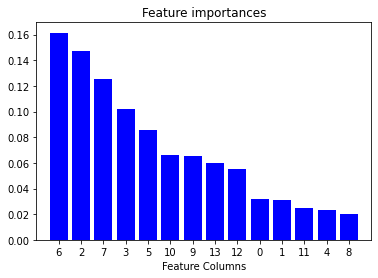

In [42]:
feature_importance = rf_model.feature_importances_
indices = np.argsort(feature_importance)[::-1]
num_features = processed_train_data.shape[1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), feature_importance[indices],
        color="blue", align="center")
plt.xticks(range(num_features), indices)
plt.xlim([-1, num_features])
plt.xlabel("Feature Columns")
plt.show()